Add formulas

Statistical
Clustering

Viz:
Make 2 clustering graph
First Graph
Correct Pyvis graphs
Nice2Have pyvis graph of clustering


# GPT-4

## Network Construction
Create a bipartite graph of holders (investors) and companies based on the investment relationships.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read dataset from CSV
data = pd.read_csv('data/climate_risks_and_holders_appetance.csv', dtype={'cik_group':'str'})

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in data.iterrows():
    holder = row["Holder"]
    company = row["comp"]
    target_7_risks = row["target_7_risks"]
    value = row["Value"]
    
    # Add the source node (Holder)
    if holder not in G.nodes:
        G.add_node(holder, type="Holder")
        
    # Add the target node (Company)
    if company not in G.nodes:
        G.add_node(company, type="Company", size=target_7_risks)
        
    # Add the edge (Value)
    G.add_edge(holder, company, value=value)

## Visualization 
Visualize the network graph to gain an initial understanding of the relationships between holders and companies. Color-code and size the nodes based on the target_7_risks scores and node types (holders and companies) to emphasize differences in risk profiles.

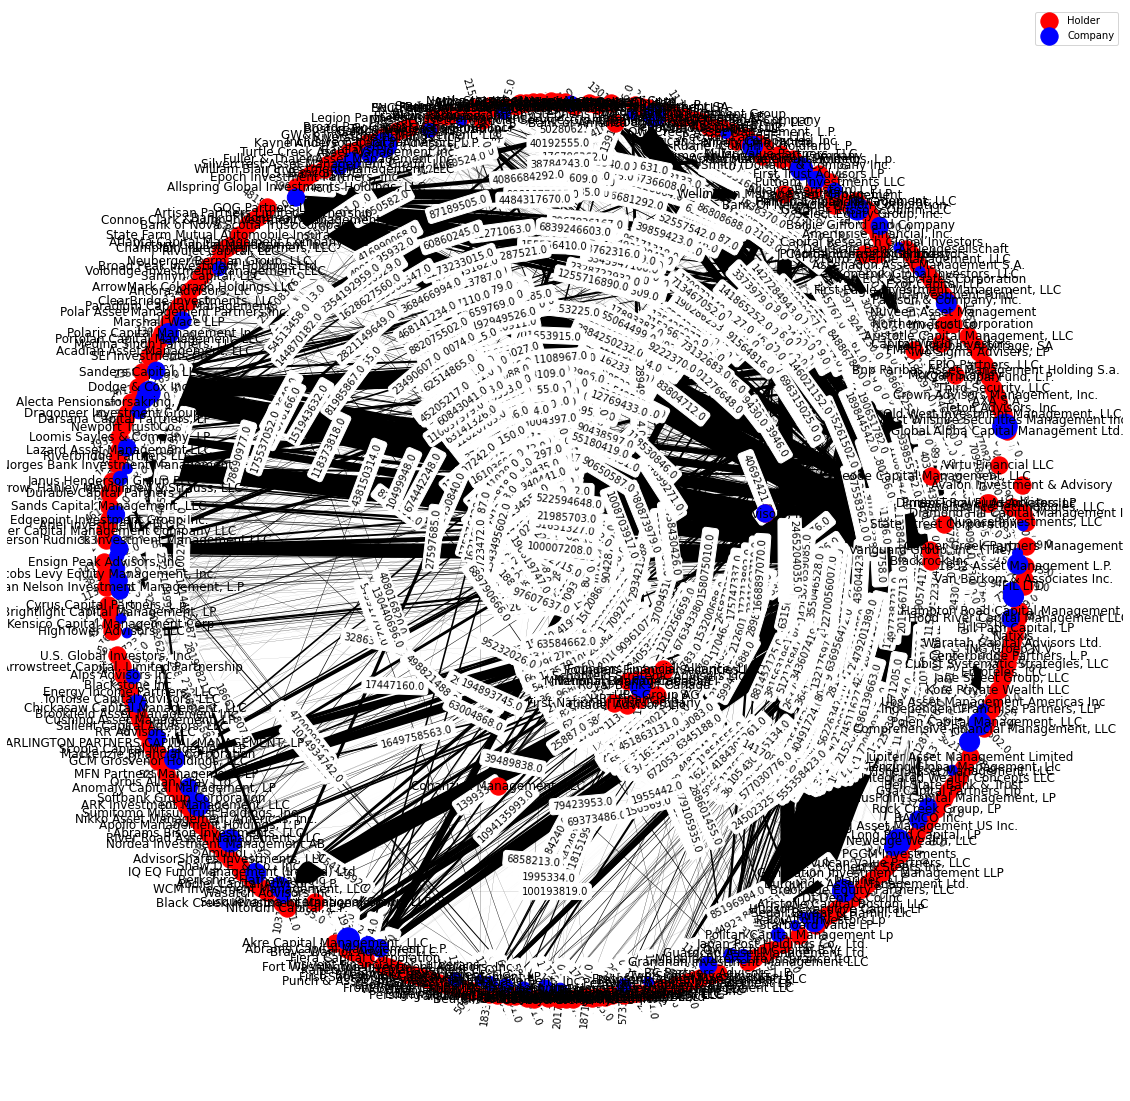

In [2]:
# Visualize the graph
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G, scale=10, weight='value')  # Use the Kamada-Kawai layout
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]["type"] == "Holder"], node_color="red", label="Holder")
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]["type"] == "Company"], node_color="blue", node_size=[G.nodes[n]["size"] * 100 for n in G.nodes if G.nodes[n]["type"] == "Company"], label="Company")
nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color="black", arrowstyle="->", arrowsize=10, width=[G.edges[e]["value"] / 1_000_000_000 for e in G.edges])
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes if G.nodes[n]["type"] == "Holder"}, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G.edges[u, v]["value"] for u, v in G.edges}, font_size=10)

plt.legend()
plt.axis("off")
plt.show()


## Centrality Analysis

Node Degree Analysis
Node degree refers to the number of edges connected to a node. In the context of your data, a company with a high degree has many holders investing in it, and a holder with a high degree invests in many companies. By analyzing node degrees, you can identify popular companies that attract many holders and active holders that invest in multiple companies.

Centrality Measures
Centrality measures help identify the importance of nodes within a network. For example, a company with high betweenness centrality is a bridge between different communities, while a company with high eigenvector centrality is connected to other important companies. Analyzing centrality measures can reveal the influential companies and holders in the network.


In [4]:
# Calculate centrality measures for company nodes
comp_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'Company']
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Filter centrality measures for company nodes only
comp_degree_centrality = {node: degree_centrality[node] for node in comp_nodes}
comp_betweenness_centrality = {node: betweenness_centrality[node] for node in comp_nodes}
comp_eigenvector_centrality = {node: eigenvector_centrality[node] for node in comp_nodes}


Imagine there are two companies: Company A has a node degree of 10, and Company B has a node degree of 2. This indicates that Company A attracts more holders (10 holders) compared to Company B (2 holders).

Suppose Company A has a betweenness centrality of 0.1, while Company B has a betweenness centrality of 0.05. Company A serves as a bridge between different communities more than Company B. Similarly, if Company A has a higher eigenvector centrality than Company B, it is connected to more influential companies and holders.

## Assortativity Analysis

The assortativity coefficient measures the tendency of nodes to connect to similar nodes. A positive assortativity coefficient indicates that nodes with similar degrees tend to connect with each other (e.g., popular companies being invested in by active holders). A negative assortativity coefficient suggests nodes with different degrees are more likely to connect (e.g., popular companies being invested in by holders with few investments). By calculating the assortativity coefficient, you can understand the overall structure and behavior patterns in the network.

In [5]:
# Calculate the assortativity coefficient based on the target_7_risks attribute
risks_assortativity = nx.attribute_assortativity_coefficient(G, 'target_7_risks')


/Users/fafa/miniforge3/envs/mlp/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:261: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


Let's say the assortativity coefficient of the network is 0.2, which is a positive value. This suggests that nodes with similar degrees (e.g., popular companies and active holders) tend to connect with each other.

## Statistical Analysis

By calculating the correlation between different attributes (e.g., centrality measures, risk scores, and investment amounts), you can identify if there are any patterns or relationships between these variables. For example, a positive correlation between investment amounts and target_7_risks scores would suggest that holders tend to invest more in companies with higher risk exposure.

In [7]:
import scipy.stats as stats

# Perform correlation analysis between centrality measures and target_7_risks scores
risk_scores = [data['target_7_risks'] for _, data in G.nodes(data=True) if data['type'] == 'Company']

degree_corr, _ = stats.pearsonr(list(comp_degree_centrality.values()), risk_scores)
betweenness_corr, _ = stats.pearsonr(list(comp_betweenness_centrality.values()), risk_scores)
eigenvector_corr, _ = stats.pearsonr(list(comp_eigenvector_centrality.values()), risk_scores)


KeyError: 'target_7_risks'

Imagine the correlation between investment amounts and target_7_risks scores is 0.4, which is a positive value. This indicates that holders tend to invest more in companies with higher target_7_risks scores.

## Risk Profile Clustering

By clustering companies based on their risk profiles (e.g., target_7_risks scores), you can identify groups of companies with similar risk exposure. This can help you understand if certain clusters of companies are more attractive to holders than others, indicating a preference for specific risk profiles.

In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare data for clustering
features = np.array([list(comp_degree_centrality.values()), list(comp_betweenness_centrality.values()), risk_scores]).T

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)

# Assign cluster labels to company nodes
for node, cluster_label in zip(comp_nodes, kmeans.labels_):
    G.nodes[node]['cluster_label'] = cluster_label


ModuleNotFoundError: No module named 'sklearn'

Imagine there are two clusters of companies based on target_7_risks scores: Cluster 1 has an average score of 3, and Cluster 2 has an average score of 7. If holders invest more in Cluster 2 companies, it suggests they prefer companies with higher risk exposure.

## Louvain community detection

Using Louvain community detection is indeed an alternative approach to clustering the companies based on their risk profiles. While k-means is a general-purpose clustering algorithm, Louvain is a method specifically designed for detecting communities in networks.

The Louvain method has the advantage of directly taking into account the network structure, which can lead to a more meaningful grouping of companies based on their relationships with investors and their risk profiles. Here's how you can apply the Louvain community detection algorithm to the company nodes in the graph

Community Detection

Using community detection algorithms like Louvain, you can identify groups of companies and holders that are more densely connected within the network. These communities might indicate that holders have preferences for specific groups of companies, which can be further analyzed to understand the underlying reasons for these preferences.

In [18]:
import community as community_louvain

# Run the Louvain community detection algorithm on the full graph
partition = community_louvain.best_partition(G)

# Filter the communities for company nodes only
comp_partition = {node: community_label for node, community_label in partition.items() if G.nodes[node]['node_type'] == 'Company'}

# Assign community labels to company nodes
for node, community_label in comp_partition.items():
    G.nodes[node]['community_label'] = community_label


TypeError: Bad graph type, use only non directed graph

Suppose the Louvain algorithm identifies three communities within the network. Analyzing these communities, you may find that holders in Community 1 prefer investing in companies with low target_7_risks scores, while holders in Community 2 prefer high target_7_risks companies.

## Pysvis visualisation

To create an interactive plot with different colors for the holders and companies

In [ ]:
from pyvis.network import Network

G_pyvis = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)
G_pyvis.barnes_hut()

# Add nodes and edges from the NetworkX graph
for node, data in G.nodes(data=True):
    node_type = G.nodes[node]['type']
    node_color = '#ff5733' if node_type == 'Holder' else '#33ffbd'
    node_size = 20
    G_pyvis.add_node(node, node, color=node_color, size=node_size)

for source, target, data in G.edges(data=True):
    G_pyvis.add_edge(source, target, value=G[source][target]['value'])

G_pyvis.show("graph_holder_and_company.html")


For the second plot with communities in different colors, you first need to run the Louvain community detection algorithm and then assign colors to the nodes based on their community labels

In [21]:
import community as community_louvain

partition = community_louvain.best_partition(G)
comp_partition = {node: community_label for node, community_label in partition.items() if G.nodes[node]['type'] == 'Company'}

for node, community_label in comp_partition.items():
    G.nodes[node]['community_label'] = community_label

colors = ['#FF5733', '#33FFBD', '#FF33D9', '#9BFF33', '#FFC133', '#3355FF', '#FF3367', '#33FF58', '#A233FF', '#FF6F33']

G_pyvis_community = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)
G_pyvis_community.barnes_hut()

# Add nodes and edges with community colors
for node, data in G.nodes(data=True):
    node_type = G.nodes[node]['type']
    if node_type == 'Company':
        node_color = colors[G.nodes[node]['community_label'] % len(colors)]
    else:
        node_color = '#AAAAAA'
    node_size = 20
    G_pyvis_community.add_node(node, node, color=node_color, size=node_size)

for source, target, data in G.edges(data=True):
    G_pyvis_community.add_edge(source, target, value=G[source][target]['value'])

G_pyvis_community.show("graph_communities.html")


TypeError: Bad graph type, use only non directed graph

Correlation Analysis

By calculating the correlation between different attributes (e.g., centrality measures, risk scores, and investment amounts), you can identify if there are any patterns or relationships between these variables. For example, a positive correlation between investment amounts and target_7_risks scores would suggest that holders tend to invest more in companies with higher risk exposure.

In [ ]:
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Read the data
#data = pd.read_csv("holder_data.csv")

# Create a NetworkX graph
G_nx = nx.DiGraph()

# Add nodes and edges to the NetworkX graph
for index, row in data.iterrows():
    G_nx.add_node(row["Holder"], node_type="Holder")
    G_nx.add_node(row["comp"], node_type="comp", target_7_risks=row["target_7_risks"])
    G_nx.add_edge(row["Holder"], row["comp"], value=row["Value"])

# Create a PyVis Network
G_pyvis = Network(notebook=True, height="750px", width="100%")

# Add nodes and edges from the NetworkX graph to the PyVis network
for node, node_attrs in G_nx.nodes(data=True):
    node_size = 30 if node_attrs["node_type"] == "Holder" else 5 * node_attrs["target_7_risks"]
    node_color = "blue" if node_attrs["node_type"] == "Holder" else "red"
    G_pyvis.add_node(node, size=node_size, color=node_color, title=node)

for source, target, edge_attrs in G_nx.edges(data=True):
    G_pyvis.add_edge(source, target, value=edge_attrs["value"], title=edge_attrs["value"])

# Set some global options for the network
G_pyvis.set_options("""
  var options = {
    "edges": {
      "color": {
        "inherit": true
      },
      "smooth": false
    },
    "physics": {
      "barnesHut": {
        "gravitationalConstant": -80000,
        "centralGravity": 0.3
      },
      "minVelocity": 0.75,
      "timestep": 0.5
    }
  }
""")

# Show the PyVis network
G_pyvis.show("holder_comp_graph_largest.html")


In [86]:
import numpy as np

In [89]:
for _, row in df.iterrows():
    G.add_node(row['Holder'], node_type='Holder')
    G.add_node(row['comp'], node_type='comp', target_7_risks=row['target_7_risks'])
    G.add_edge(row['Holder'], row['comp'], value=row['Value']*np.exp(100))
# Add nodes and edges from the NetworkX graph
for node, data in G.nodes(data=True):
    node_type = G.nodes[node]
    node_color = '#ff5733' if node_type == 'Holder' else '#33ffbd'
    node_size = 20
    G_pyvis.add_node(node, node, color=node_color, size=node_size)

for source, target, data in G.edges(data=True):
    G_pyvis.add_edge(source, target, value=G[source][target]['value'])

# Set node sizes based on 'target_7_risks'
scale_factor = 1
for node, data in G.nodes(data=True):
    if G.nodes[node]['node_type'] == 'comp':
        G_pyvis.get_node(node)['size'] = G.nodes[node]['target_7_risks'] * scale_factor

# Configure physics
G_pyvis.toggle_physics(False)

# Show the graph
G_pyvis.show("climate_risks_and_holders_graph.html")


In [77]:
G_pyvis.get_node(node)['size']

20

In [78]:
G.nodes[node]['target_7_risks']

1

In [98]:
import json


In [108]:
for _, row in df.iterrows():
    G.add_node(row['Holder'], node_type='Holder')
    G.add_node(row['comp'], node_type='comp', target_7_risks=row['target_7_risks'])
    G.add_edge(row['Holder'], row['comp'], value=row['Value']*np.exp(100))

# Add nodes and edges from the NetworkX graph
for node, data in G.nodes(data=True):
    node_type = G.nodes[node]['node_type']
    node_color = '#ff5733' if node_type == 'Holder' else '#33ffbd'
    node_size = 20
    G_pyvis.add_node(node, node, color=node_color, size=node_size)

for source, target, data in G.edges(data=True):
    G_pyvis.add_edge(source, target, value=G[source][target]['value'])

# Set node sizes based on 'target_7_risks'
scale_factor = 1
for node, data in G.nodes(data=True):
    if G.nodes[node]['node_type'] == 'comp':
        G_pyvis.get_node(node)['size'] = G.nodes[node]['target_7_risks'] * scale_factor

import json

# Configure physics
options = {
    "physics": {
        "enabled": True,
        "barnesHut": {
            "gravitationalConstant": -6000,
            "centralGravity": 0.0,
            "springLength": 500,
            "springConstant": 0.01,
            "damping": 0.5,
            "avoidOverlap": 1
        }
    }
}
G_pyvis.set_options(options)

# Show the graph
G_pyvis.show("climate_risks_and_holders_graph33.html")


AttributeError: 'dict' object has no attribute 'set'

In [15]:
df=pd.read_csv('data/climate_risks_and_holders_appetance.csv')

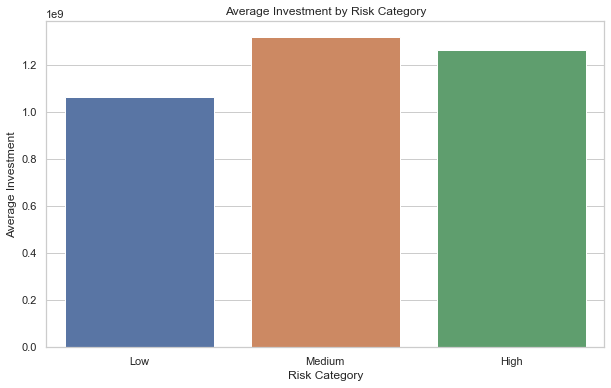

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create bins for target_7_risks scores
bin_labels = ['Low', 'Medium', 'High']
bins = pd.cut(df['target_7_risks'], bins=[0, 2, 4, 8], labels=bin_labels)

# Calculate the average investment in each bin
average_investment_per_bin = df.groupby(bins)['Value'].mean()

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_investment_per_bin.index, y=average_investment_per_bin)
ax.set(xlabel='Risk Category', ylabel='Average Investment')
plt.title('Average Investment by Risk Category')
plt.show()


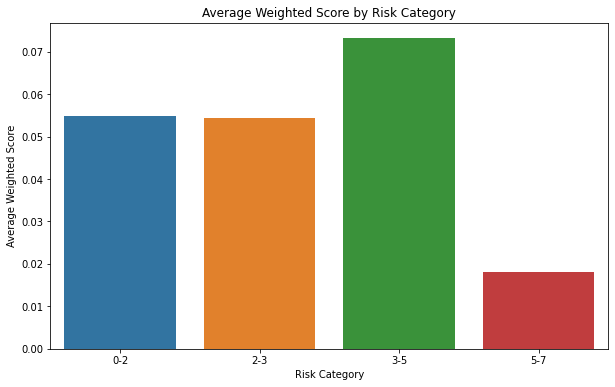

In [4]:
import seaborn as sns

# Calculate the total investment for each company
investment_per_company = df.groupby('comp')['Value'].sum().reset_index(name='total_investment')
# Add market cap column to the dataframe
investment_per_company= pd.merge(investment_per_company, df[['comp','Market_cap']].drop_duplicates(), on='comp')
# Calculate the degree centrality for each company
degree_centrality = nx.degree_centrality(G)
degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree_centrality'])

# Normalize the degree centrality, amount invested, and market cap
investment_per_company['normalized_investment'] = investment_per_company['total_investment'] / investment_per_company['total_investment'].max()
investment_per_company['normalized_market_cap'] = investment_per_company['Market_cap'] / investment_per_company['Market_cap'].max()
degree_centrality['normalized_degree_centrality'] = degree_centrality['degree_centrality'] / degree_centrality['degree_centrality'].max()

# Merge the dataframes
merged_data = pd.merge(investment_per_company, degree_centrality, left_on='comp', right_index=True)

# Compute the weighted score
weights = [0.4, 0.4, 0.2]  # You can adjust the weights based on your preference
merged_data['weighted_score'] = merged_data['normalized_investment'] * weights[0] + \
                                merged_data['normalized_market_cap'] * weights[1] + \
                                merged_data['normalized_degree_centrality'] * weights[2]

# Merge with the original dataframe to get target_7_risks scores
final_data = pd.merge(merged_data, df[['comp', 'target_7_risks']].drop_duplicates(), on='comp')

# Create bins for target_7_risks scores and calculate the average weighted score in each bin
#bin_labels = ['Low', 'Medium', 'High']
investment_per_company = pd.merge(investment_per_company, df[['comp', 'target_7_risks']].drop_duplicates(), on='comp')
custom_bins = [0, 2, 3, 5, 7]
custom_labels = ['0-2', '2-3', '3-5', '5-7']
investment_per_company['target_7_risks_bins'] = pd.cut(investment_per_company['target_7_risks'], bins=custom_bins, labels=custom_labels)
investment_per_company['target_7_risks_bins'] = investment_per_company['target_7_risks_bins'].fillna('0-2')
bins = pd.cut(final_data['target_7_risks'], bins=custom_bins, labels=custom_labels)
average_weighted_score_per_bin = final_data.groupby(bins)['weighted_score'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_weighted_score_per_bin.index, y=average_weighted_score_per_bin)
ax.set(xlabel='Risk Category', ylabel='Average Weighted Score')
plt.title('Average Weighted Score by Risk Category')
plt.show()


In [101]:
investment_per_company.head()

comp  total_investment    Market_cap  normalized_investment  \
0  ABBV      9.054931e+10  1.730000e+11               0.413184   
1  ACCO      2.172762e+08  7.000000e+08               0.000991   
2   AFL      1.482196e+10  2.590000e+10               0.067634   
3   ALK      2.087256e+09  4.400000e+09               0.009524   
4  AMED      1.657500e+09  6.400000e+09               0.007563   

   normalized_market_cap  target_7_risks target_7_risks_bins  
0               0.267429               0                 0-2  
1               0.001082               0                 0-2  
2               0.040037               2                 0-2  
3               0.006802               0                 0-2  
4               0.009893               4                 3-5

In [102]:
final_data.head()

comp  total_investment    Market_cap  normalized_investment  \
0  ABBV      9.054931e+10  1.730000e+11               0.413184   
1  ACCO      2.172762e+08  7.000000e+08               0.000991   
2   AFL      1.482196e+10  2.590000e+10               0.067634   
3   ALK      2.087256e+09  4.400000e+09               0.009524   
4  AMED      1.657500e+09  6.400000e+09               0.007563   

   normalized_market_cap  degree_centrality  normalized_degree_centrality  \
0               0.267429                0.0                           NaN   
1               0.001082                0.0                           NaN   
2               0.040037                0.0                           NaN   
3               0.006802                0.0                           NaN   
4               0.009893                0.0                           NaN   

   weighted_score  target_7_risks  
0             NaN               0  
1             NaN               0  
2             NaN               2  
3             NaN               0  
4             NaN               4

In [51]:
average_weighted_score_per_bin.head()

target_7_risks
0-2    0.054864
2-3    0.054451
3-5    0.073189
5-7    0.018077
Name: weighted_score, dtype: float64

In [12]:



# Calculate the total investment for each company
investment_per_company = df.groupby('comp')['Value'].sum().reset_index(name='total_investment')

# Calculate the degree centrality for each company
degree_centrality = nx.degree_centrality(G)
degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree_centrality'])
investment_per_company

comp  total_investment
0    ABBV      9.054931e+10
1    ACCO      2.172762e+08
2     AFL      1.482196e+10
3     ALK      2.087256e+09
4    AMED      1.657500e+09
..    ...               ...
137   XPO      2.803517e+09
138  XSPA      7.413280e+06
139  XXII      4.154275e+07
140  YELP      1.445931e+09
141  ZUMZ      2.234097e+08

[142 rows x 2 columns]

In [57]:
# Calculate betweenness and eigenvector centrality
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Convert them to dataframes
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness_centrality'])
eigenvector_df = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['eigenvector_centrality'])

# Normalize the centralities
betweenness_df['normalized_betweenness_centrality'] = betweenness_df['betweenness_centrality'] / betweenness_df['betweenness_centrality'].max()
eigenvector_df['normalized_eigenvector_centrality'] = eigenvector_df['eigenvector_centrality'] / eigenvector_df['eigenvector_centrality'].max()

# Merge the dataframes
merged_data = pd.merge(merged_data, betweenness_df, left_on='comp', right_index=True)
merged_data = pd.merge(merged_data, eigenvector_df, left_on='comp', right_index=True)

# Compute the new weighted score
weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # You can adjust the weights based on your preference
merged_data['new_weighted_score'] = merged_data['normalized_investment'] * weights[0] + \
                                    merged_data['normalized_market_cap'] * weights[1] + \
                                    merged_data['normalized_degree_centrality'] * weights[2] + \
                                    merged_data['normalized_betweenness_centrality'] * weights[3] + \
                                    merged_data['normalized_eigenvector_centrality'] * weights[4]

# Merge with the original dataframe to get target_7_risks scores
final_data = pd.merge(merged_data, df[['comp', 'target_7_risks']].drop_duplicates(), on='comp')

# Create bins for target_7_risks scores and calculate the average new weighted score in each bin
bins = pd.cut(final_data['target_7_risks'], bins=[0, 0.33, 0.66, 1], labels=bin_labels)
average_new_weighted_score_per_bin = final_data.groupby(bins)['new_weighted_score'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_new_weighted_score_per_bin.index, y=average_new_weighted_score_per_bin)
ax.set(xlabel='Risk Category', ylabel='Average New Weighted Score')


KeyError: 'normalized_betweenness_centrality'

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G)

# Convert them to dataframes
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness_centrality'])
eigenvector_df = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['eigenvector_centrality'])

# Normalize the centralities
betweenness_df['normalized_betweenness_centrality'] = betweenness_df['betweenness_centrality'] / betweenness_df['betweenness_centrality'].max()
eigenvector_df['normalized_eigenvector_centrality'] = eigenvector_df['eigenvector_centrality'] / eigenvector_df['eigenvector_centrality'].max()

# Merge the dataframes
merged_data = pd.merge(merged_data, betweenness_df, left_on='comp', right_index=True)
merged_data = pd.merge(merged_data, eigenvector_df, left_on='comp', right_index=True)

# Compute the new weighted score
weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # You can adjust the weights based on your preference
merged_data['new_weighted_score'] = merged_data['normalized_investment'] * weights[0] + \
                                    merged_data['normalized_market_cap'] * weights[1] + \
                                    merged_data['normalized_degree_centrality'] * weights[2] + \
                                    merged_data['normalized_betweenness_centrality'] * weights[3] + \
                                    merged_data['normalized_eigenvector_centrality'] * weights[4]

# Merge with the original dataframe to get target_7_risks scores
final_data = pd.merge(merged_data, df[['comp', 'target_7_risks']].drop_duplicates(), on='comp')

# Create bins for target_7_risks scores and calculate the average new weighted score in each bin
bins = pd.cut(final_data['target_7_risks'], bins=[0, 0.33, 0.66, 1], labels=bin_labels)
average_new_weighted_score_per_bin = final_data.groupby(bins)['new_weighted_score'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_new_weighted_score_per_bin.index, y=average_new_weighted_score_per_bin)
ax.set(xlabel='Risk Category', ylabel='Average New Weighted Score')


In [60]:
# Calculate betweenness and eigenvector centrality
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Convert them to dataframes
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness_centrality'])
eigenvector_df = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['eigenvector_centrality'])

betweenness_centrality  \
Blackrock Inc.                                           0.0   
CALM                                                     0.0   
Vanguard Group, Inc. (The)                               0.0   
Nuance Investments, LLC                                  0.0   
Diamond Hill Capital Management Inc                      0.0   
...                                                      ...   
BAH                                                      0.0   
1832 Asset Management L.P.                               0.0   
IQV                                                      0.0   
HSC                                                      0.0   
Cooper Creek Partners Management LLC                     0.0   

                                      normalized_betweenness_centrality  
Blackrock Inc.                                                      NaN  
CALM                                                                NaN  
Vanguard Group, Inc. (The)                                          NaN  
Nuance Investments, LLC                                             NaN  
Diamond Hill Capital Management Inc                                 NaN  
...                                                                 ...  
BAH                                                                 NaN  
1832 Asset Management L.P.                                          NaN  
IQV                                                                 NaN  
HSC                                                                 NaN  
Cooper Creek Partners Management LLC                                NaN  

[452 rows x 2 columns]

In [63]:
eigenvector_df

eigenvector_centrality  \
Blackrock Inc.                                      0.000109   
CALM                                                0.084320   
Vanguard Group, Inc. (The)                          0.000109   
Nuance Investments, LLC                             0.000109   
Diamond Hill Capital Management Inc                 0.000109   
...                                                      ...   
BAH                                                 0.084320   
1832 Asset Management L.P.                          0.000109   
IQV                                                 0.084320   
HSC                                                 0.084320   
Cooper Creek Partners Management LLC                0.000109   

                                      normalized_eigenvector_centrality  
Blackrock Inc.                                                 0.001297  
CALM                                                           1.000000  
Vanguard Group, Inc. (The)                                     0.001297  
Nuance Investments, LLC                                        0.001297  
Diamond Hill Capital Management Inc                            0.001297  
...                                                                 ...  
BAH                                                            1.000000  
1832 Asset Management L.P.                                     0.001297  
IQV                                                            1.000000  
HSC                                                            1.000000  
Cooper Creek Partners Management LLC                           0.001297  

[452 rows x 2 columns]

In [6]:
# Get a list of all nodes with 'type' attribute set to 'Holder'
holder_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'Holder']

# Remove all 'Holder' nodes from the graph
G.remove_nodes_from(holder_nodes)

# Calculate betweenness and eigenvector centrality for the subgraph
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
betweenness_centrality

{'CALM': 0.0,
 'ITHUF': 0.0,
 'PME': 0.0,
 'LMNR': 0.0,
 'AQB': 0.0,
 'CTVA': 0.0,
 'NG': 0.0,
 'HCC': 0.0,
 'EOG': 0.0,
 'MLM': 0.0,
 'MDC': 0.0,
 'PHM': 0.0,
 'NVR': 0.0,
 'TMHC': 0.0,
 'J': 0.0,
 'DY': 0.0,
 'BBCP': 0.0,
 'AMRC': 0.0,
 'BLD': 0.0,
 'PEP': 0.0,
 'MDLZ': 0.0,
 'KDP': 0.0,
 'MO': 0.0,
 'XXII': 0.0,
 'CRWS': 0.0,
 'PVH': 0.0,
 'VFC': 0.0,
 'CTAS': 0.0,
 'GES': 0.0,
 'KTB': 0.0,
 'CVCO': 0.0,
 'EVA': 0.0,
 'LPX': 0.0,
 'JELD': 0.0,
 'LZB': 0.0,
 'LEG': 0.0,
 'ACCO': 0.0,
 'PFE': 0.0,
 'AMGN': 0.0,
 'ABBV': 0.0,
 'COP': 0.0,
 'IMO': 0.0,
 'ATR': 0.0,
 'CROX': 0.0,
 'FWRD': 0.0,
 'CAL': 0.0,
 'SKX': 0.0,
 'TGLS': 0.0,
 'GLW': 0.0,
 'MU': 0.0,
 'MCHP': 0.0,
 'NVDA': 0.0,
 'APH': 0.0,
 'PTON': 0.0,
 'BA': 0.0,
 'HEI': 0.0,
 'LMT': 0.0,
 'JBHT': 0.0,
 'APTV': 0.0,
 'MAT': 0.0,
 'GOLF': 0.0,
 'UPS': 0.0,
 'KNX': 0.0,
 'ARCB': 0.0,
 'SAIA': 0.0,
 'NCLH': 0.0,
 'INSW': 0.0,
 'LPG': 0.0,
 'DAL': 0.0,
 'ALK': 0.0,
 'JBLU': 0.0,
 'SKYW': 0.0,
 'HEP': 0.0,
 'PAGP': 0.0,
 'VRRM': 0.0